## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

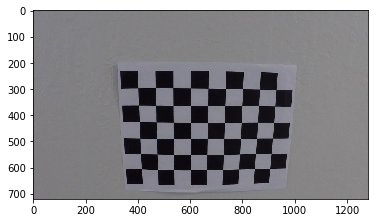

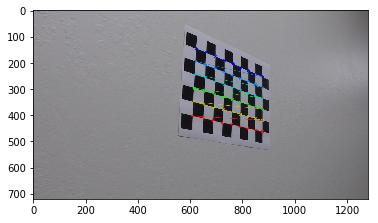

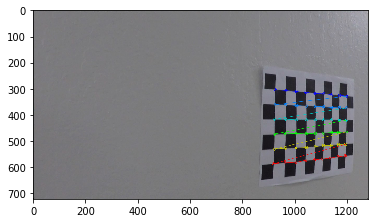

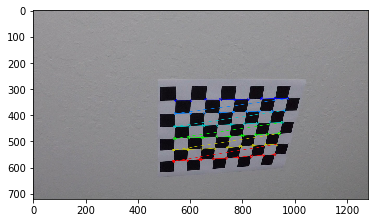

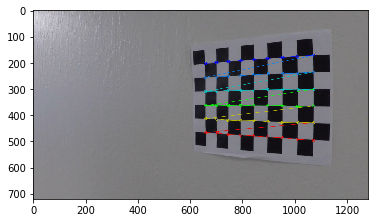

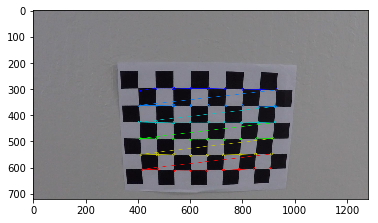

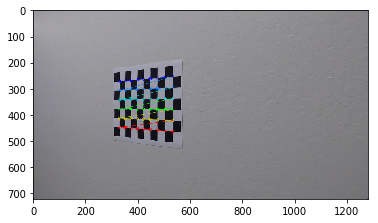

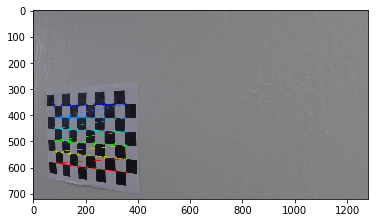

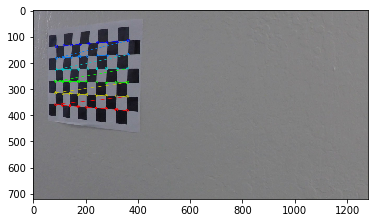

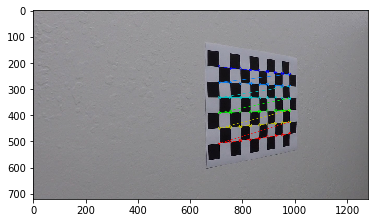

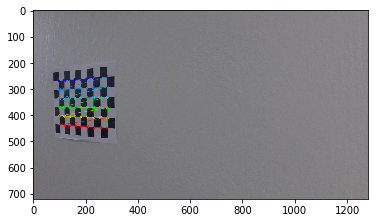

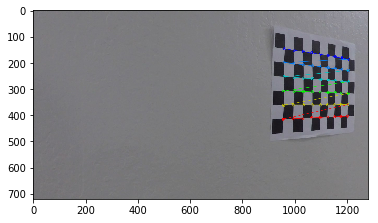

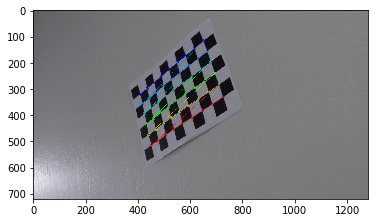

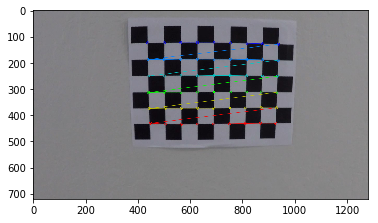

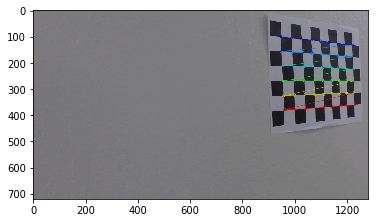

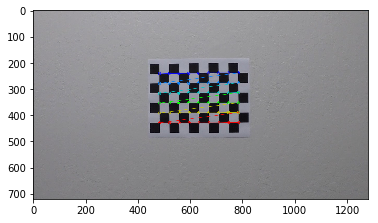

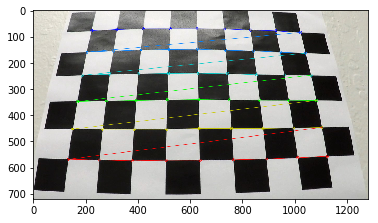

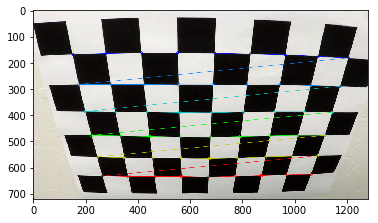

In [2]:
import numpy as np
import time
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
img = mpimg.imread(images[5])

plt.figure()
plt.imshow(img)
# plt.show()



# Step through the list and search for chessboard corners

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

        
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)    


## Second, I'll apply distortion correction on the raw images


[[  1.15777818e+03   0.00000000e+00   6.67113857e+02]
 [  0.00000000e+00   1.15282217e+03   3.86124583e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[-0.24688507 -0.02373155 -0.00109831  0.00035107 -0.00259866]]


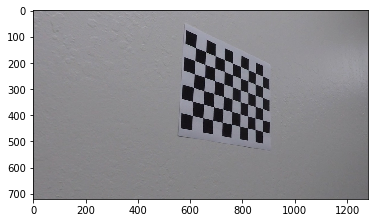

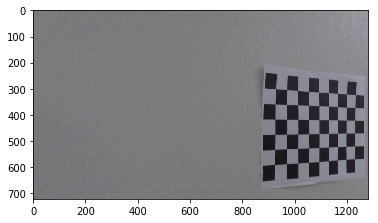

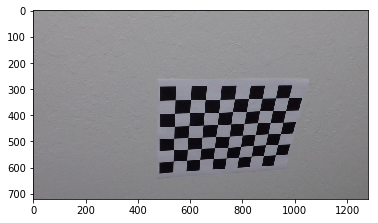

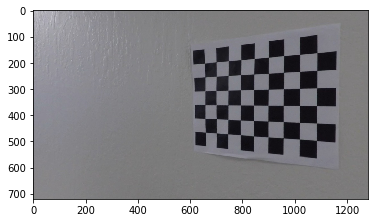

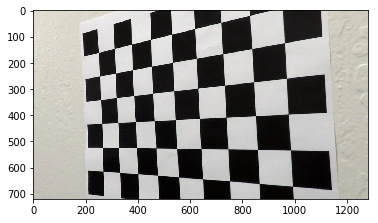

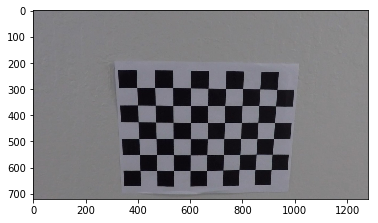

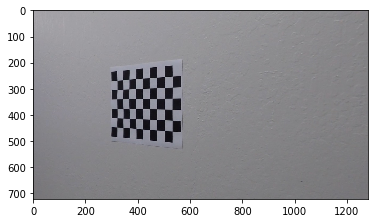

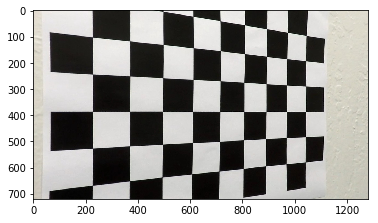

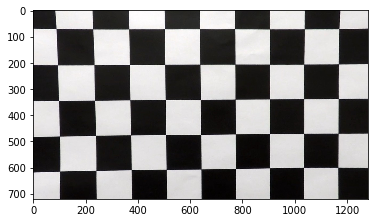

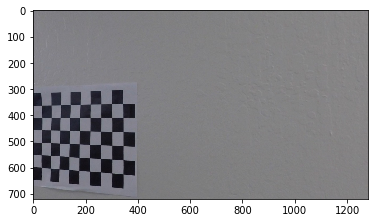

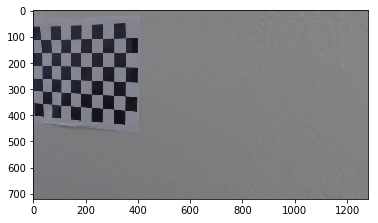

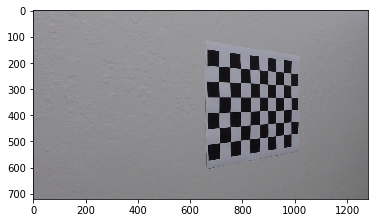

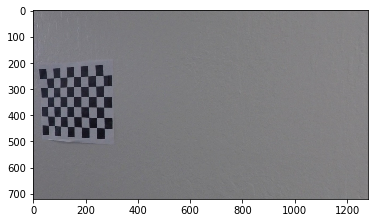

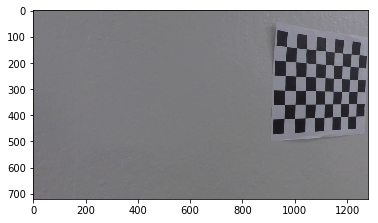

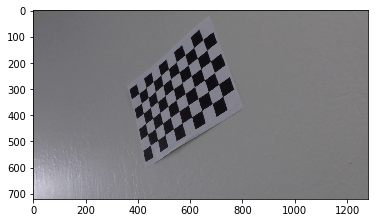

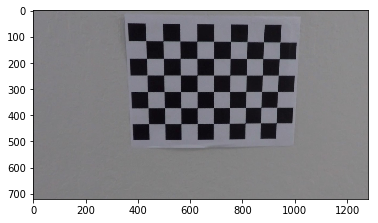

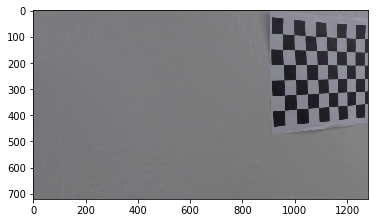

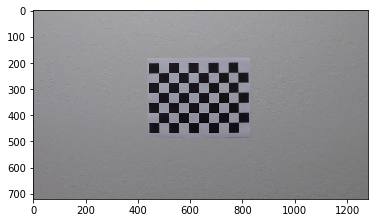

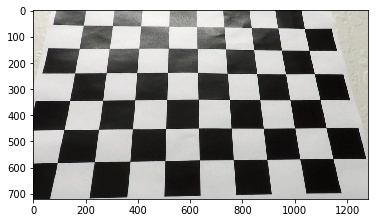

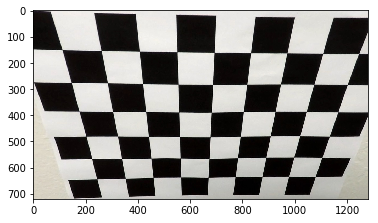

In [3]:
# Step through the list and undistort each image
print(mtx)
print(dist)
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure()
    plt.imshow(undistorted)




## Third, I'll use color transforms, gradients, etc., to create a thresholded binary image.


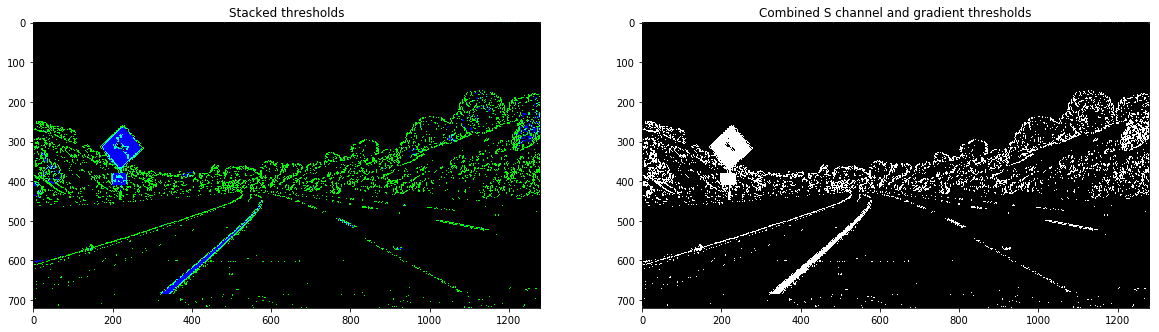

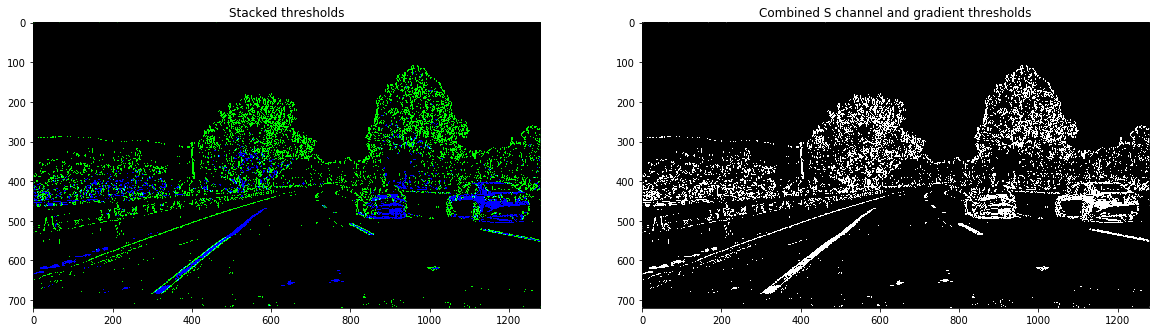

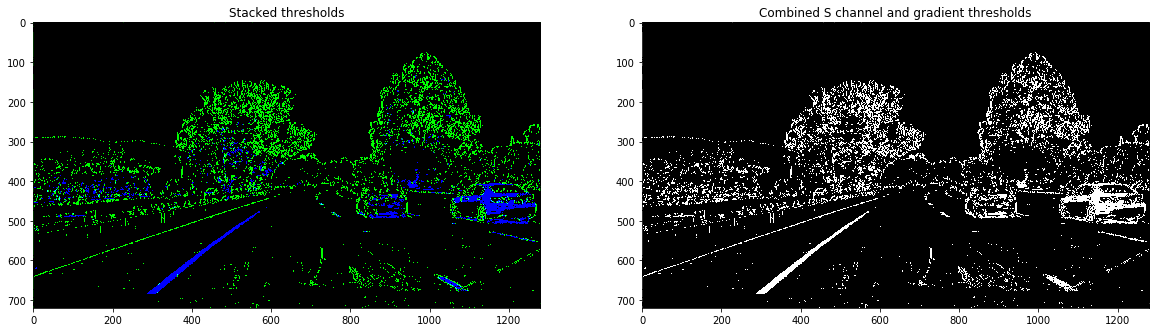

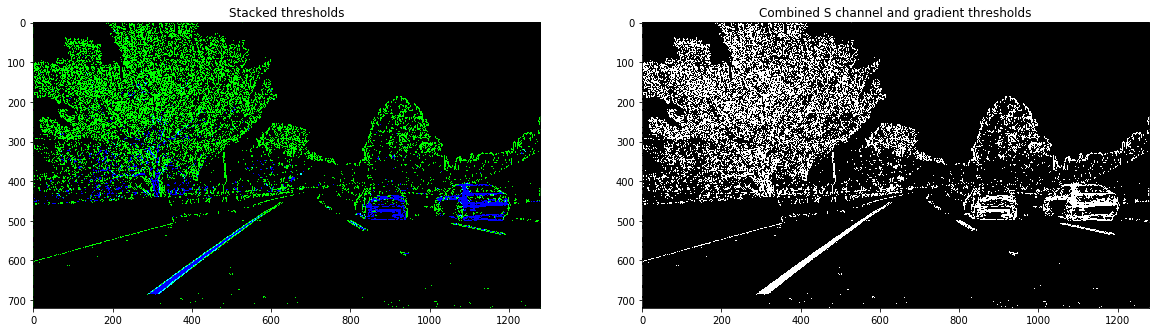

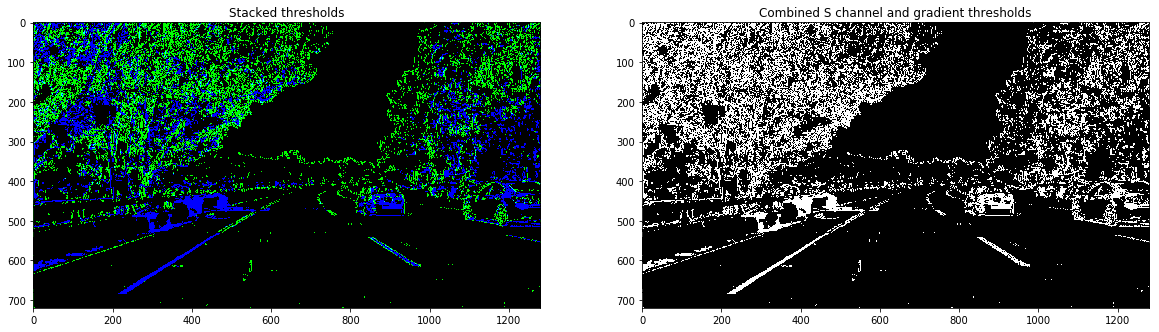

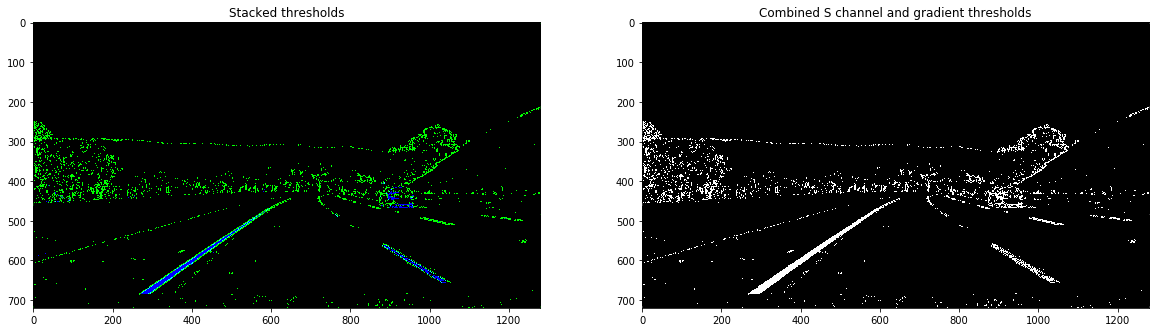

In [10]:
def create_binary_threshold_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')
    return combined_binary
    
# Make a list of road images
images = glob.glob('../test_images/test*.jpg')
binary_threshold_images=[]
for fname in images:
    img  = mpimg.imread(fname)
    binary_threshold_images.append(create_binary_threshold_image(img))
    
    

    


## Fourth, I'll apply a perspective transform to rectify the binary images.

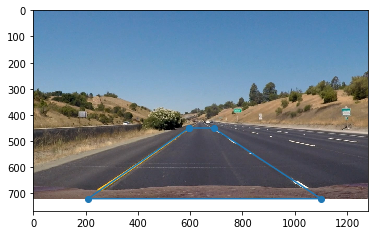

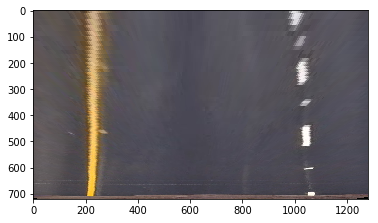

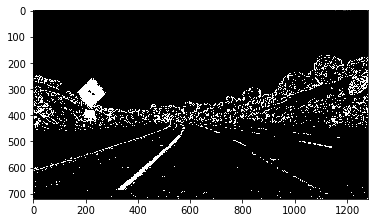

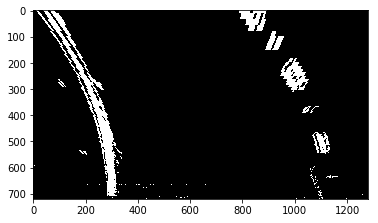

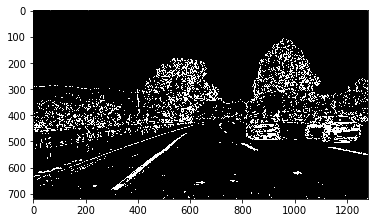

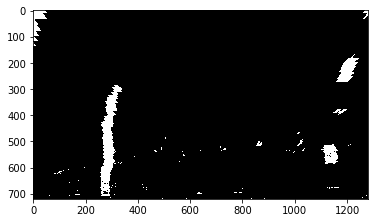

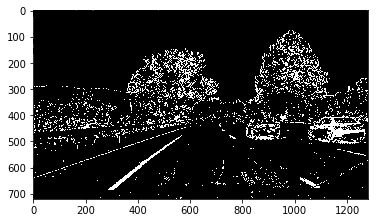

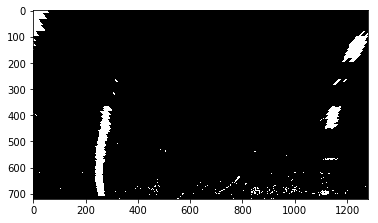

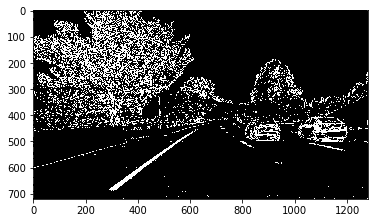

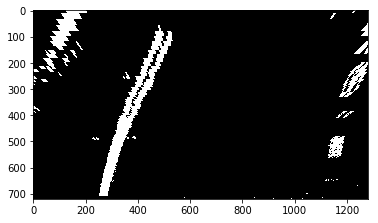

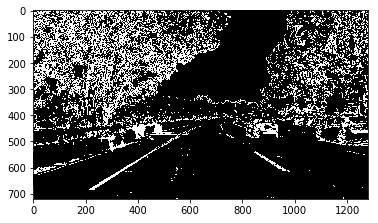

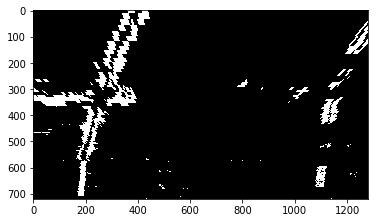

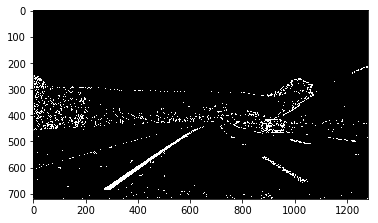

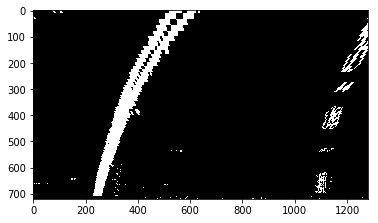

In [38]:
def warp_image(img,M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)


#Load straight lane lines image 
images = glob.glob('../test_images/straight_lines*.jpg')
img = mpimg.imread(images[0])

plt.figure()
plt.imshow(img)

offset = 225 # offset for dst points
img_size = (img.shape[1], img.shape[0])


# # # For source points I'm selecting four corners of a trapezoid

src = np.float32([(595,450),(690,450),(1100,720) ,(210,720)])


# # # Code used to select source points by eyeballing 
x=[]
y=[]
for point in src:
    x.append(point[0])
    y.append(point[1])

x.append(src[0][0])
y.append(src[0][1])
plt.scatter(x,y)
plt.plot(x, y)
# # For destination points, I'm arbitrarily choosing some points to be
# # arranged in a rectangle and fit the offset value 

dst = np.float32([[offset, 0], [img_size[0] - offset, 0], 
                             [img_size[0]-offset, img_size[1]], 
                             [offset, img_size[1]]])


# # Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
M_inv= cv2.getPerspectiveTransform(dst,src)
# # Warp the image using OpenCV warpPerspective()
warped = warp_image(img, M)
plt.figure()
plt.imshow(warped)


# # # Testing perspective transform on second straight lane lines image
# img = mpimg.imread(images[1])
# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(warped)

# # # Testing perspective transform on curved lane lines image
# img = mpimg.imread(glob.glob('../test_images/test2.jpg')[0])
# warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(warped)

binary_warped_images=[]
for bin_img in binary_threshold_images:
    binary_warped = warp_image(bin_img,M)
    binary_warped_images.append(binary_warped)
    plt.figure()
    plt.imshow(bin_img, cmap='gray')
    plt.figure()
    plt.imshow(binary_warped, cmap='gray')


## Fifth, I'll detect lane pixels and fit to find the lane boundary.

Left fit:
[ -5.00928599e-04   7.09848423e-01   5.15700090e+01]
Right fit:
[ -6.38996369e-04   8.51663129e-01   8.26791295e+02]
Left fit:
[  2.63311567e-04  -3.40535193e-01   3.90116308e+02]
Right fit:
[  3.02328964e-04  -4.29242820e-01   1.28287132e+03]
Left fit:
[  5.01704907e-04  -6.31862374e-01   4.52938144e+02]
Right fit:
[  5.03261997e-04  -6.18729360e-01   1.31139247e+03]
Left fit:
[  1.98045677e-04  -5.53719988e-01   5.54978783e+02]
Right fit:
[ -7.62673559e-05  -2.11435350e-01   1.28915962e+03]
Left fit:
[  5.14933995e-04  -6.71291254e-01   4.09372630e+02]
Right fit:
[  6.07130367e-04  -7.32249120e-01   1.32046944e+03]
Left fit:
[  3.60338670e-04  -6.85681103e-01   5.56871046e+02]
Right fit:
[  3.65621750e-04  -5.76636106e-01   1.32230062e+03]


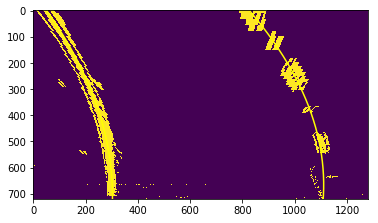

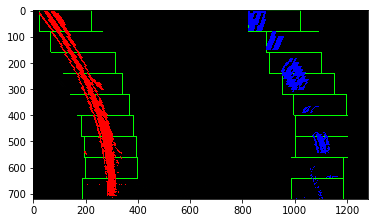

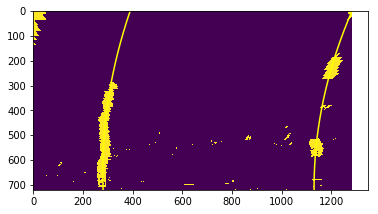

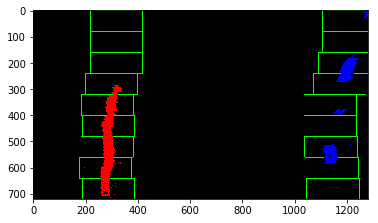

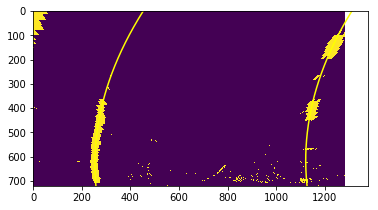

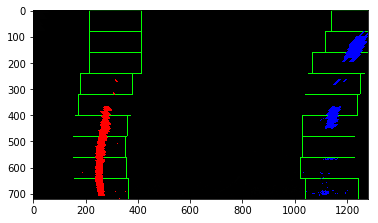

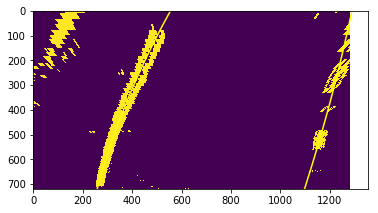

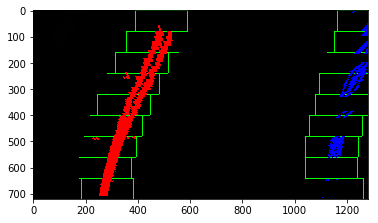

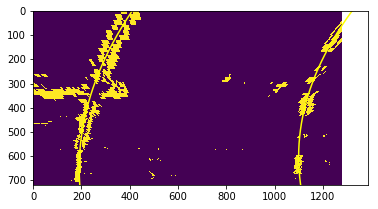

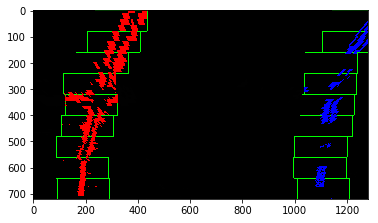

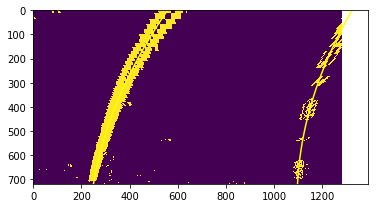

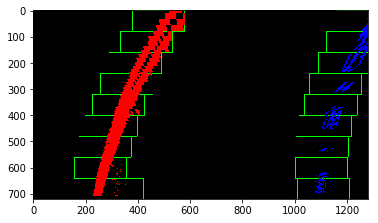

In [25]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low =  rightx_current-margin
        win_xright_high =  rightx_current+margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if (len(good_left_inds)>=minpix):
            #recenter left
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds)>=minpix):
            #recenter right
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx , 2)
    right_fit = np.polyfit(righty,rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

for img in binary_warped_images:
    plt.figure()
    plt.imshow(img)
    out_img = fit_polynomial(img)
    plt.figure()
    plt.imshow(out_img)
 
    

## Sixth, I'll determine the curvature of the lane and vehicle position with respect to center.

In [54]:
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    img_shape=binary_warped.shape
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
 
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    #####  calculation of R_curve (radius of curvature) #####

    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**(3/2))/(np.abs(2*left_fit_cr[0]))
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**(3/2))/(np.abs(2*right_fit_cr[0]))
    
    ## To find vehicle position: Assume car/camera is positioned at the center of the image base
    ## The position is determined by averaging the x values of each polynomial at the bottom of the image 
    y = y_eval
    print(y)
    x_pos_left= y**2*left_fit_cr[0]+y*left_fit_cr[1]+left_fit_cr[2]
    x_pos_right=y**2*right_fit_cr[0]+y*right_fit_cr[1]+right_fit_cr[2]
    vehicle_position=((x_pos_left)+(x_pos_right))/2
    return left_curverad, right_curverad,vehicle_position


# Calculate the radius of curvature in meters for both lane lines

left_curverad, right_curverad, vehicle_position= measure_curvature_real(binary_warped_images[0])

print(left_curverad, 'm', right_curverad, 'm', vehicle_position, 'm')

29.9583333333
363.654209761 m 373.387837484 m 2.30344160811 m


## Seventh, I'll warp the detected lane boundaries back onto the original image.

## Eighth, I'll output:
## a) a visual display of the lane boundaries
## b) a numerical estimation of lane curvature 
## c) the vehicle position